In [1]:
# Imports
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})

# Import dataframe
df = pd.read_csv(r"C:\Users\m.al-zadid\OneDrive - Washington State University (email.wsu.edu)\WSU Pullman\Coursework\7th Semester\CPT_S 575\Project\Main Dataset.csv")

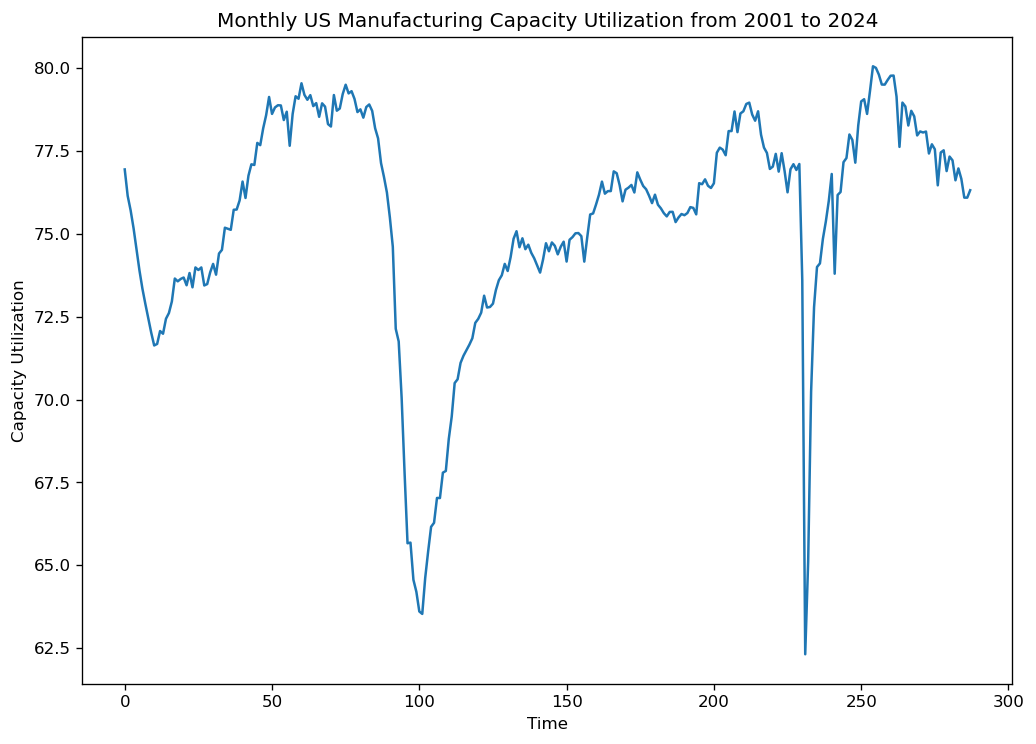

In [150]:
# Time series plot
plt.plot(df['caputil'])
plt.xlabel('Time')
plt.ylabel('Capacity Utilization')
plt.title('Monthly US Manufacturing Capacity Utilization from 2001 to 2024')
plt.show()

In [133]:
#Stationarity Check

from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.caputil.dropna())
print('ADF Statistic: %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic: -2.511006
p-value: 0.112819


p-value is >0.05 significance level. So, we do not reject the null hypothesis and conclude that there is no evidence that the series is stationary. So, now we seelct the order d of differencing and see how the autocorrelation plot will look like. 

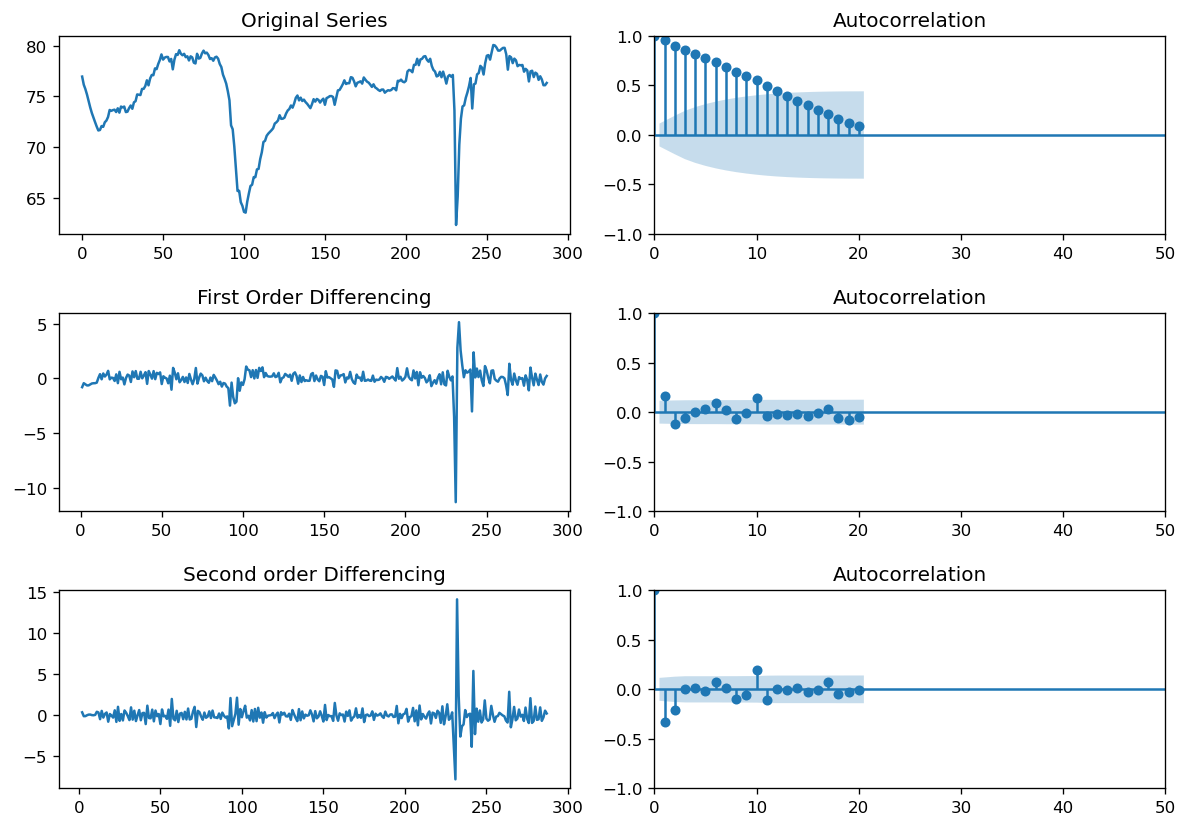

In [134]:
# selecitng the differencing order d

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3,2, sharex=False)

# Original series
axes[0,0].plot(df.caputil); axes[0,0].set_title('Original Series')
plot_acf(df.caputil, ax=axes[0,1], lags=20); axes[0,1].set_xlim(0, 50)

# First differencing
axes[1,0].plot(df.caputil.diff()); axes[1,0].set_title('First Order Differencing')
plot_acf(df.caputil.diff().dropna(),ax=axes[1,1], lags=20); axes[1,1].set_xlim(0, 50)

#Second Differencing
axes[2,0].plot(df.caputil.diff().diff()); axes[2,0].set_title('Second order Differencing')
plot_acf(df.caputil.diff().diff().dropna(), ax=axes[2,1], lags=20); axes[2,1].set_xlim(0, 50)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()



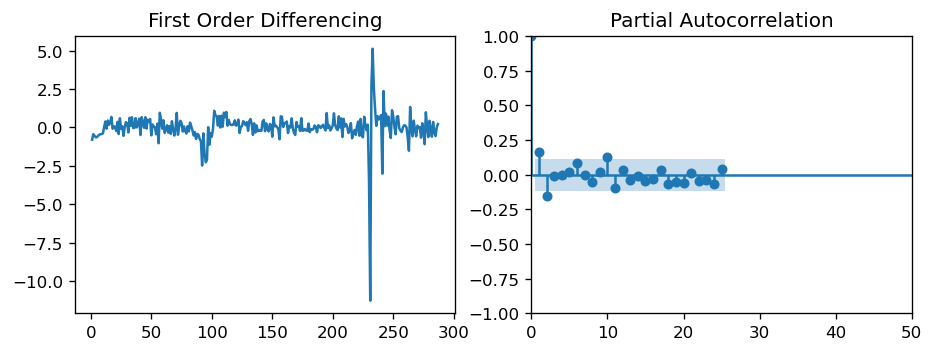

In [135]:
# selecting the AR order p
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes= plt.subplots(1,2,sharex=False)
axes[0].plot(df.caputil.diff()); axes[0].set_title('First Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.caputil.diff().dropna(), ax=axes[1]); axes[1].set_xlim(0, 50)
plt.show()

In [ ]:
### Auto ARIMA

In [136]:
import warnings
warnings.filterwarnings("ignore")

In [137]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df.caputil,
                     start_p = 1,
                     start_q = 1,
                     test = 'adf',
                     max_p = 3,
                     max_q = 3,
                     m=1,
                     d= None,
                     seasonal = False,
                     start_P = 0,
                     D = 0,
                     trace = True,
                     error_action = 'ignore',
                     suppress_warnings = True,
                     stepwise = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=794.705, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=802.761, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=797.118, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=794.473, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=800.763, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=793.439, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=794.846, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=794.532, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=796.459, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=791.440, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=792.475, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=792.847, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=792.533, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=792.706, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=794.4

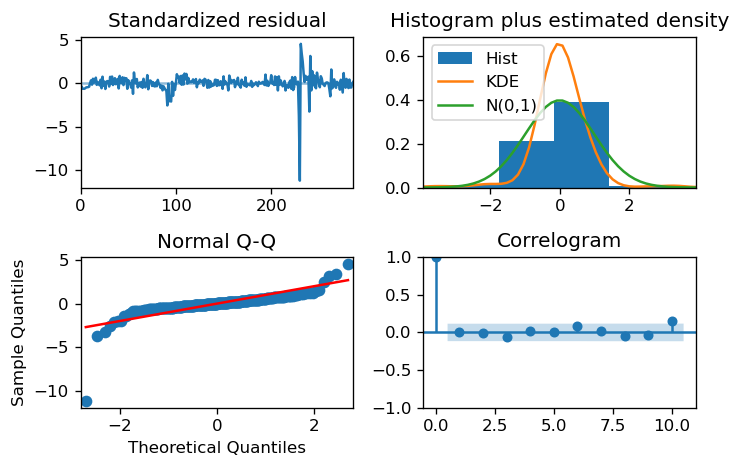

In [138]:
model.plot_diagnostics(figsize=(6,4))
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

## incorporating intervention shock before forecasting

# creating intervention dummy
df.index = pd.to_datetime(df.index)
df["intervention"] = (df.index >= pd.Timestamp("2020-04-01")).astype(int)



## train test 90-10 split
n = len(df)
train_size = int(n * 0.90)

train = df.iloc[:train_size]
test  = df.iloc[train_size:]


## fitting ARIMA and forecast

model = sm.tsa.SARIMAX(
    train["caputil"],
    order=(0,1,2),
    exog=train[["intervention"]]
).fit()

steps = len(test)

forecast = model.get_forecast(
    steps=steps,
    exog=test[["intervention"]]
)

y_pred = forecast.predicted_mean
y_true = test["caputil"]

## MAPE and RMSE
mape = np.mean(np.abs((y_true - y_pred) / y_true))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))

print("MAPE:", mape)
print("RMSE:", rmse)


C:\Users\m.al-zadid\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
C:\Users\m.al-zadid\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


MAPE: 0.02313851198026863
RMSE: 2.0395327552943963


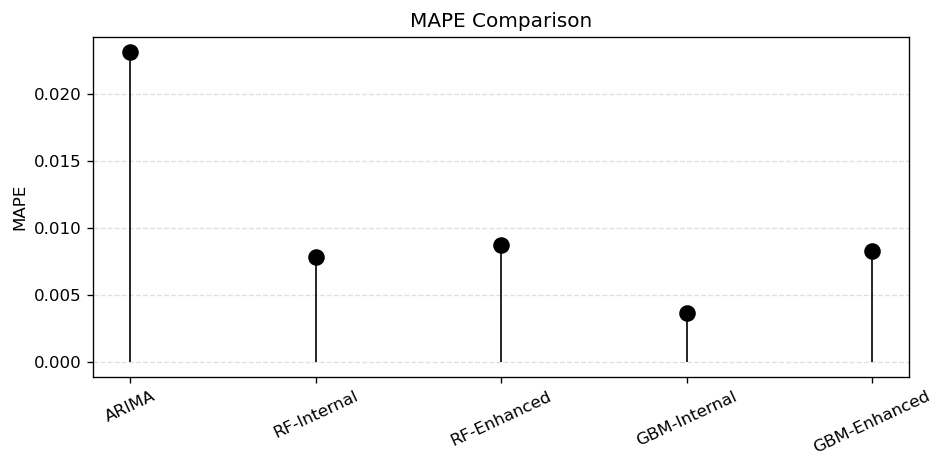

In [3]:
import matplotlib.pyplot as plt

models = ["ARIMA", "RF-Internal", "RF-Enhanced",
          "GBM-Internal", "GBM-Enhanced"]

mape_values = [0.0231, 0.0078, 0.0087, 0.0036, 0.0083]

plt.figure(figsize=(8,4))

markerline, stemlines, baseline = plt.stem(models, mape_values, basefmt=" ")
plt.setp(stemlines, color="black", linewidth=1)
plt.setp(markerline, color="black")

plt.scatter(models, mape_values, color="black", s=80)

plt.title("MAPE Comparison")
plt.ylabel("MAPE")
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


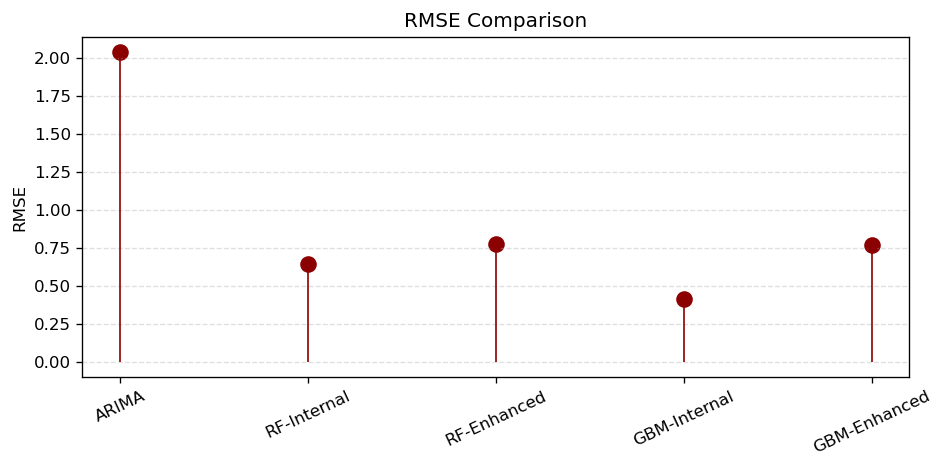

In [4]:
import matplotlib.pyplot as plt

models = ["ARIMA", "RF-Internal", "RF-Enhanced",
          "GBM-Internal", "GBM-Enhanced"]

rmse_values = [2.0395, 0.6415, 0.7731, 0.4165, 0.7714]

plt.figure(figsize=(8,4))

markerline, stemlines, baseline = plt.stem(models, rmse_values, basefmt=" ")
plt.setp(stemlines, color="darkred", linewidth=1)
plt.setp(markerline, color="darkred")

plt.scatter(models, rmse_values, color="darkred", s=80)

plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()
